In [2]:
import pandas as pd
import numpy as np
import os
import re
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

import calendar

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.dates as pld
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('more_tweets_plus.csv')

In [4]:
df2 = df[df.tweet_clean.notnull()]

In [5]:
df2['date'] = pd.to_datetime(df2['date'])

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [6]:
df2['day'] = df2.date.dt.to_period('D').map(lambda x: x.strftime('%Y-%m-%d'))

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
df2i = df2.set_index('day')

In [8]:
df2i.index.max()

'2018-08-01'

In [9]:
cv = CountVectorizer(stop_words='english')
v_tweets = cv.fit_transform(df2)
gram1 = pd.DataFrame(v_tweets.todense(), columns=cv.get_feature_names()).sum().sort_values(ascending=False)

In [10]:
df2.date.dt.to_period('D').nunique()

574

In [11]:
stops = nltk.corpus.stopwords.words('english')
train_words = ['train', 'trains', 'st', 'av', 'http', 'custhelp']
stops = stops+train_words

In [12]:
def lemma(t, lem=None):
    if (lem is None) or (type(lem) != WordNetLemmatizer):
        lem = WordNetLemmatizer()
    t_lem = []
    for w in t.split():
        t_lem.append(lem.lemmatize(w))
    return ' '.join(t_lem)

In [13]:
def stem(t, stem=None):
    if (stem is None):
        stem = PorterStemmer()
    t_stem = []
    for w in t.split():
        t_stem.append(stem.stem(w))
    return ' '.join(t_stem)

In [14]:
def span_vec_day(day, data=df2, n_grams=(1,1), pro='stem', norm=False, binary=False):
    tweets = data.set_index('day').loc[day]['tweet_clean']
    if pro == 'stem':
        t_pro = tweets.map(stem)
    elif pro == 'lem':
        t_pro = tweets.map(lemma)
    else:
        t_pro = tweets
    cv = CountVectorizer(ngram_range=n_grams, stop_words=stops, binary=binary)
    v_tweets = cv.fit_transform(t_pro)
    gram = pd.DataFrame(
        pd.DataFrame(v_tweets.todense(),
                                    columns=cv.get_feature_names()).sum().sort_values(ascending=False)
        ).rename(columns={0:'count'})
    if norm:
        gram['norm'] = gram['count'].map(lambda x: x/len(tweets))
    return gram

In [15]:
def vec_day_top_n(n=25, start=False, end=False, data=df2, n_grams=(1,1), pro='stem', norm=False, binary=False):
    d_i = data.set_index('day')
#     if not start:
#         start = d_i.index.min()
#     if not end:
#         end = d_i.index.max()
    df = pd.DataFrame()
    for d in d_i.index.unique():
        if d[-1] == '1':
            clear_output()
        gram = span_vec_day(day=d, data=data, n_grams=n_grams, norm=norm, pro=pro, binary=binary)
        df_gram = pd.DataFrame(gram).reset_index().rename(columns={'index':'word',0:'count'}).iloc[0:n,:]
        df_gram['date'] = d
        df = pd.concat([df, df_gram])
        print(d) 
    return df.sort_values('date').reset_index(drop=True)

In [16]:
df2i.index

Index(['2018-08-01', '2018-08-01', '2018-08-01', '2018-08-01', '2018-08-01',
       '2018-08-01', '2018-08-01', '2018-08-01', '2018-08-01', '2018-08-01',
       ...
       '2017-01-05', '2017-01-05', '2017-01-05', '2017-01-05', '2017-01-05',
       '2017-01-05', '2017-01-05', '2017-01-05', '2017-01-05', '2017-01-05'],
      dtype='object', name='day', length=149072)

In [17]:
d_range = pd.date_range('2017-01-01', periods=574, freq='D')

In [18]:
day_by_sig = df2[['day','sig','tweet_clean']].groupby(['day','sig']).count()

In [19]:
sig_clean = {'^JG':['^JG','^Jg', '^JG\\', '^jG'],
'^JP':['^JP','^JP.', '^JP^J', '^JJP', '^^JP'],
'^BD':['^BD', '^BDht','^BDpi', '^B', '^BD^B'],
'^KF':['^KF', '^KFht', 'KFpi'],
'^GES':['^GES', '^GSht', '^GES"', '^G.S.', '^G..S', '^G.', '^GES:', '^G.S,', '^G.S>', '^^GS', '^G,S.'],
'^DG':['^DG', '^DGq', '^Dg', '^DGG', '^DG.'],
'^JZ':['^JZ','^JZZ', '^Z'],
'^HKD':['^HKD'],
'^RT':['^RT', '^RT^R', '^RTht', '^rt', '^RTGO'],
'^EE':['^EE', '^EE^E', '^EE.'],
'^JH':['^JH'],
'^SL':['^SL','^SL"'],
'^JV':['^JV','^JVht'],
'^TCB':['^TCB'],
'^DM':['^DM','^DMpi', '^^DM'],
'^JL':['^JL', '^JL"', '^JLpi', '^Jl'],
'^CB':['^CB', '^Cb', '^Cb"'],
'^MB':['^MB'],
'^TB':['^TB', '^TBJ', 'TCB.', '^TB^T', '^tb'],
'^DP':['^DP', '^DP:'],
'^AM':['^AM', '^Am'],
'^IR':['^IR'],
'^JF':['^JF'],
'^TBJ':['^TBJ', '^TBJ.'],
'^NOC':['^NOC'],
'^MW':['^MW','^MWht', '^MWpi'],
'^DJP':['^DJP'],
'^ML':['^ML', 'MLpi'],
'^PI':['^PI', '^PI.'],
'^ABht':['ABht'],
'None':[None]}

In [20]:
sigs = ['^JG', '^JP', '^BD', '^KF', '^GES', '^DG', '^JZ', '^HKD', '^RT', '^EE', '^JH', '^SL', '^JV', '^TCB', '^DM', '^JL', '^CB', '^MB', '^TB', '^DP', '^AM', '^IR', '^JF', '^TBJ', '^NOC', '^MW', '^DJP', '^ML', '^PI', '^ABht']

In [21]:
sig_ref = {}
for k, v in sig_clean.items():
    for i in v:
        sig_ref[i] = k

In [22]:
df2['sig_clean'] = df2['sig'].map(lambda x: sig_ref[x] if x in sig_ref.keys() else x)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
df2.sig_clean.unique()

array(['^JZ', '^CB', nan, '^DJP', '^BD', '^KF', '^JV', '^DM', '^SL', '^JP',
       '^TBJ', '^AM', '^RT', '^GES', '^RT"', '^EE', '^JVpi', '^JG', '^HKD',
       '^MW', '^BD"', '^JL', '^GS', '^DG', '^ML', '^Jt', '^TBJ"', '^IR',
       '^GS.', '^MLpi', '^AS', '^DP', '^KFpi', '^PI', '^JG"', '^BJ',
       '^JV.', '^KF"', '^MW"', '^HKD"', '^DGpi', '^HKDp', '^MB', '^PRS',
       '^JP"', '^CB`', '^GJ', '^NOC', '^SM', '^AB', '^ABht', '^MB"',
       '^RTpi', '^TB', '^CBH', '^xx', '^RTGo', '^^JV', '^WF', '^Mhtt',
       '^NOC"', '^xx^D', '^R', '^TB"', '^JR', '^KF(1', '^DP.', '^JF',
       '^GS"', '^CB"', '^UG', '^TCB', '^Rt', '^ER', '^DG"', '^G.S', '^JH',
       '^DGF', '^SK', '^Dp', '^G.s.', '^ges', '^Sl', '^G.S/', '^NO',
       '^TCB.', '^G', '^1703', '^P', '^SP', '^http', '^TCB,'], dtype=object)

In [24]:
sig_clean = {'^JG':['^JG','^Jg', '^JG\\', '^jG', '^JG"'],
'^JP':['^JP','^JP.', '^JP^J', '^JJP', '^^JP', '^JP"'],
'^BD':['^BD', '^BDht','^BDpi', '^B', '^BD^B', '^BD"'],
'^KF':['^KF', '^KFht', '^KFpi', '^KF"','^KF(1'],
'^GES':['^GES', '^GSht', '^GES"', '^G.S.', '^G..S', '^G.', '^GES:', '^G.S,', '^G.S>', '^^GS', 
        '^G,S.','^GS.','^GS"', '^G.S', '^G.s.', '^ges', '^G.S/', '^G', '^GS'],
'^DG':['^DG', '^DGq', '^Dg', '^DGG', '^DG.', '^DGpi','^DG"','^DGF'],
'^JZ':['^JZ','^JZZ', '^Z'],
'^HKD':['^HKD', '^HKD"', '^HKDp'],
'^RT':['^RT', '^RT^R', '^RTht', '^rt', '^RTGO', '^RTpi', '^RT"', '^Rt', '^RTGo'],
'^EE':['^EE', '^EE^E', '^EE.'],
'^JH':['^JH'],
'^SL':['^SL','^SL"', '^Sl'],
'^JV':['^JV','^JVht', '^JVpi', '^JV.', '^^JV'],
'^TCB':['^TCB', '^TCB.', '^TCB,'],
'^DM':['^DM','^DMpi', '^^DM'],
'^JL':['^JL', '^JL"', '^JLpi', '^Jl'],
'^CB':['^CB', '^Cb', '^Cb"', '^CB`','^CB"', '^CBH'],
'^MB':['^MB', '^MB"'],
'^TB':['^TB', '^TBJ', 'TCB.', '^TB^T', '^tb','^TB"'],
'^DP':['^DP', '^DP:','^DP.','^Dp'],
'^AM':['^AM', '^Am'],
'^IR':['^IR'],
'^JF':['^JF'],
'^TBJ':['^TBJ', '^TBJ.'],
'^NOC':['^NOC','^NOC"'],
'^MW':['^MW','^MWht', '^MWpi', '^MW"'],
'^DJP':['^DJP'],
'^ML':['^ML', '^MLpi'],
'^PI':['^PI', '^PI.', '^P'],
'^AB':['^AB','^ABht'],
'None':[None, 'nan','^xx^D','^R', '^1703', '^http', '^xx', '^Mhtt', '^Jt']}

In [25]:
sig_ref = {}
for k, v in sig_clean.items():
    for i in v:
        sig_ref[i] = k

In [26]:
df2['sig_clean'] = df2['sig'].map(lambda x: sig_ref[x] if x in sig_ref.keys() else x)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
df2.sig_clean.unique()

array(['^JZ', '^CB', nan, '^DJP', '^BD', '^KF', '^JV', '^DM', '^SL', '^JP',
       '^TBJ', '^AM', '^RT', '^GES', '^EE', '^JG', '^HKD', '^MW', '^JL',
       '^DG', '^ML', 'None', '^TBJ"', '^IR', '^AS', '^DP', '^PI', '^BJ',
       '^MB', '^PRS', '^GJ', '^NOC', '^SM', '^AB', '^TB', '^WF', '^JR',
       '^JF', '^UG', '^TCB', '^ER', '^JH', '^SK', '^NO', '^SP'], dtype=object)

In [28]:
day_by_sig = df2[['day','sig_clean','tweet_clean']].groupby(['day','sig_clean']).count()

In [29]:
day_by_sig = day_by_sig.reset_index().rename(columns={'sig_clean':'sig', 'tweet_clean':'count'})

In [30]:
day_by_sig.head()

,day,sig,count
0,2017-01-05,^DG,17
1,2017-01-05,^JP,17
2,2017-01-06,^BD,22
3,2017-01-06,^JG,19
4,2017-01-06,^JH,12


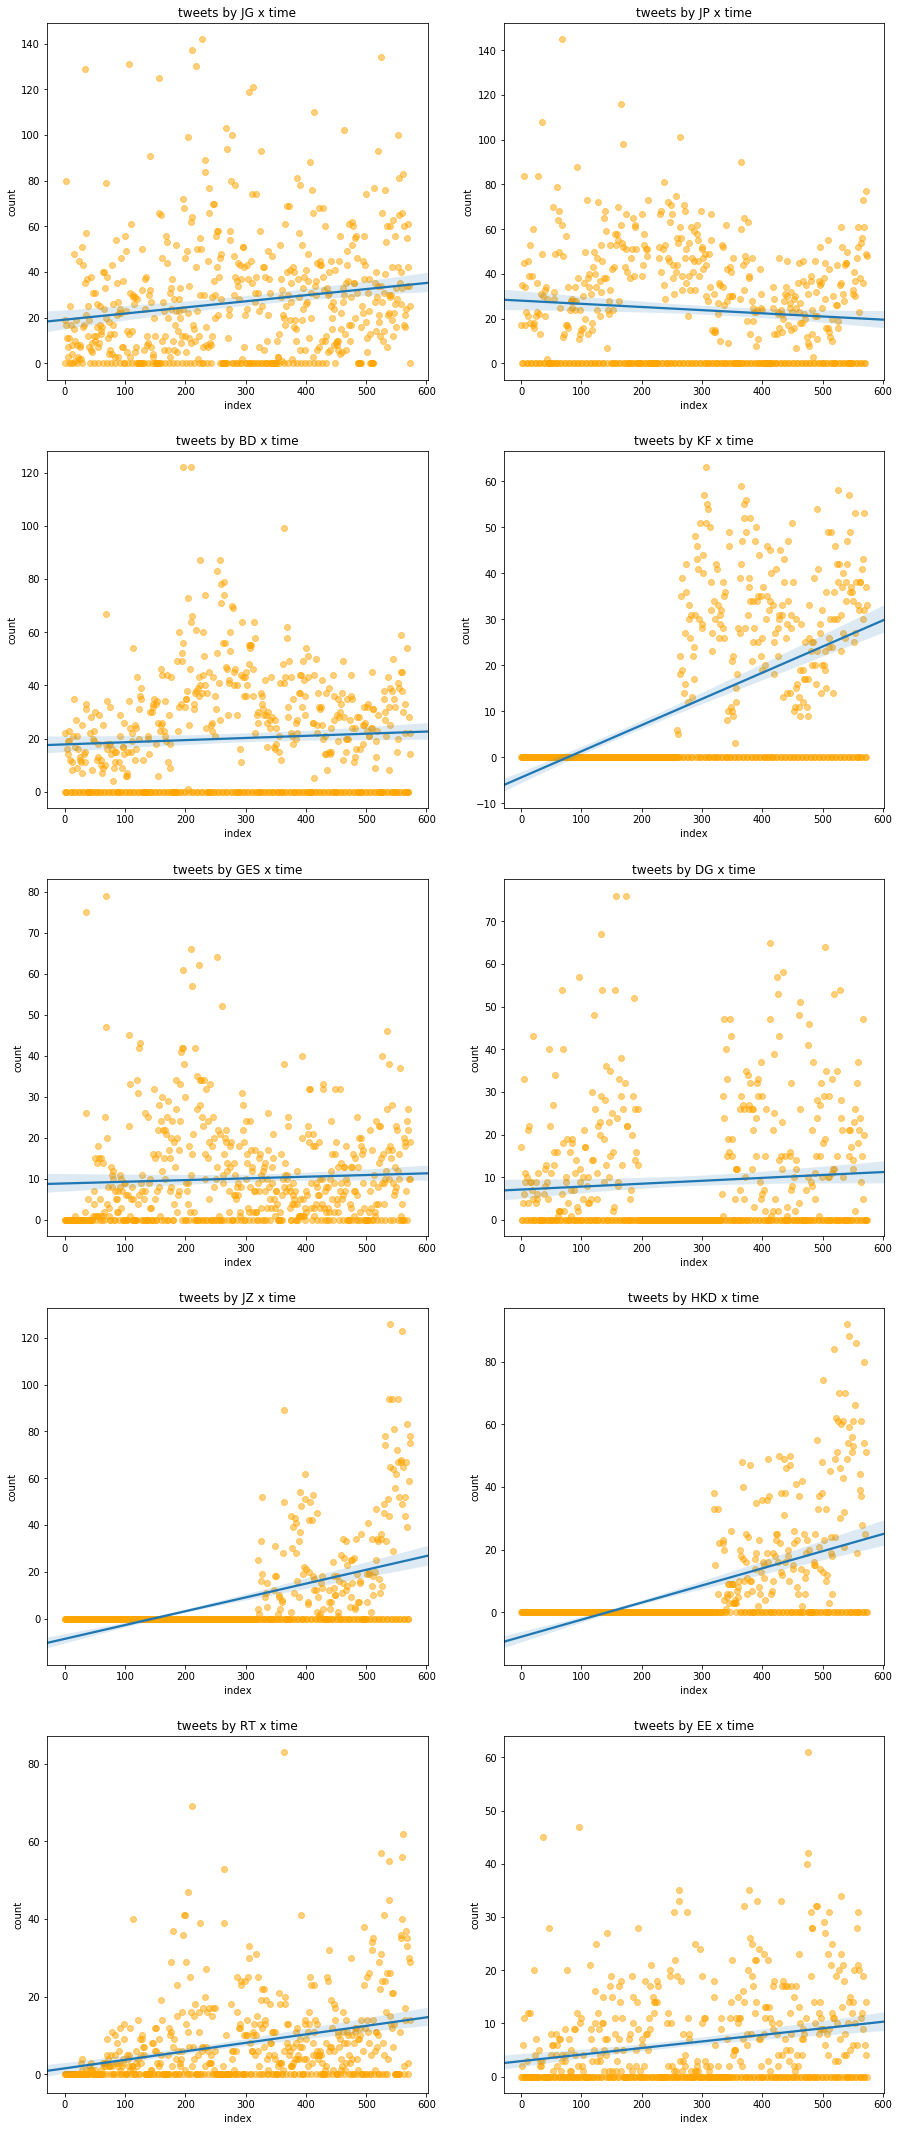

In [31]:
data = day_by_sig

plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=3,
                wspace=None, hspace=None)
auth = ['^JG', '^JP', '^BD', '^KF', '^GES', '^DG', '^JZ', '^HKD', '^RT', '^EE']

dates = data.loc[:,'day'].unique()
# if fig:
#     fig = plt.figure(figsize=(15,7))
p = 1

for a in auth:
    plt.subplot(5,2,p)
    plt.title(f'tweets by {a[1:]} x time')
    d = data[data['sig'] == a].sort_values('day')
    counts = {'date':[], 'count':[]}
    for d1 in dates:
        counts['date'].append(d1)
        if d.loc[:,'day'].str.contains(d1).sum() > 0:
            counts['count'].append(d[d['day'] == d1]['count'].values[0])
        else:
            counts['count'].append(0)
    plot_df = pd.DataFrame(counts).reset_index()
    sns.regplot(
        data=plot_df, x='index', y='count', scatter_kws=({'alpha':0.5, 'color':'orange'}))
    p += 1
# if line:
#     plt.axvline(x=line, linestyle=':')